## Real-Time Streaming Data Pipeline (Kafka → Spark → Cassandra)

This notebook walks through an end-to-end real-time data engineering pipeline:

1. Generate mock user data from an API (Random User)
2. Publish events to **Kafka** (topic: `users_created`)
3. Process events with **Spark Structured Streaming**
4. Store results in **Cassandra** (keyspace: `spark_streams`, table: `created_users`)
5. Validate and visualize the stored data


### Project goal
Build a small, reproducible streaming pipeline you can run locally with Docker.

- **Ingestion:** Kafka
- **Processing:** Spark Structured Streaming
- **Storage:** Cassandra (with TTL to avoid unlimited growth)
- **Orchestration / scheduling (optional):** Airflow


### System architecture

`Producer (Python) → Kafka → Spark Streaming → Cassandra → Analytics / Visualization`

Key components:
- **Python Producer:** generates events and sends them to Kafka
- **Kafka:** message broker / event log
- **Spark:** reads Kafka stream, parses JSON, applies basic quality checks, writes to Cassandra
- **Cassandra:** scalable NoSQL storage (table has **TTL** so old rows expire automatically)


### Technology stack
- **Orchestration:** Apache Airflow
- **Streaming:** Apache Kafka + Confluent Platform
- **Processing:** Apache Spark (Structured Streaming)
- **Storage:** Cassandra
- **Containerization:** Docker Compose
- **Language:** Python


### Notes
- This notebook contains both **learning notes** and **pipeline code**.
- Code cells use container hostnames inside Docker (e.g., `broker:29092`, `cassandra:9042`).


## Quick Kafka primer (very short)
- **Producer** publishes messages to a **topic**
- **Consumer** reads messages from a topic
- Messages are ordered per partition and tracked using **offsets**


### Kafka concepts
- **Topic:** stream/category of events (like a channel)
- **Partition:** parallelism & ordering unit
- **Broker:** Kafka server
- **Consumer group:** multiple consumers sharing the load


### Kafka data flow
1. Producer sends events to a topic (`users_created`)
2. Kafka stores events durably
3. Spark consumes the topic continuously
4. Spark writes processed rows to Cassandra


## Getting started
Make sure Docker containers are running (`docker compose up -d`).


### Step 0: Check versions inside containers (optional)
The next cell prints Python and Spark versions.


Check Python and Spark versions inside the Docker container

In [1]:
!python3 --version
!spark-submit --version

Python 3.11.6
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.5.1
      /_/
                        
Using Scala version 2.12.18, OpenJDK 64-Bit Server VM, 11.0.29
Branch HEAD
Compiled by user heartsavior on 2024-02-15T11:24:58Z
Revision fd86f85e181fc2dc0f50a096855acf83a6cc5d9c
Url https://github.com/apache/spark
Type --help for more information.


##### 1. Create mock streaming data from an API

Fetch data from an API

In [2]:
import requests
import logging

def get_data():
    url = "https://randomuser.me/api/"
    r = requests.get(url, timeout=10)
    r.raise_for_status()

    payload = r.json()
    results = payload.get("results", [])

    if not results:
        logging.error(f"RandomUser returned empty results. Payload={payload}")
        return None

    return results[0]



In [3]:
import json

print(json.dumps(get_data(), indent=3))

{
   "gender": "female",
   "name": {
      "title": "Mrs",
      "first": "Lucia",
      "last": "Gonz\u00e1lez"
   },
   "location": {
      "street": {
         "number": 7412,
         "name": "Calle del Barquillo"
      },
      "city": "Santiago de Compostela",
      "state": "Galicia",
      "country": "Spain",
      "postcode": 54392,
      "coordinates": {
         "latitude": "-36.2953",
         "longitude": "1.1035"
      },
      "timezone": {
         "offset": "-11:00",
         "description": "Midway Island, Samoa"
      }
   },
   "email": "lucia.gonzalez@example.com",
   "login": {
      "uuid": "8560bcca-71c4-4954-ab1f-db547d11e065",
      "username": "yellowsnake719",
      "password": "alphabet",
      "salt": "eWtJwrMR",
      "md5": "a73292a738cbcf058b8c730ea1b20461",
      "sha1": "5bf92f2df280861768d5ad3b25fc755ad3a846c0",
      "sha256": "053e6976163a9ea16c180301795da5e062420c30603aed554ee47f3769cc56b8"
   },
   "dob": {
      "date": "1964-12-04T12:16:02.124Z

Format the data as needed

In [4]:
import uuid

def format_data(res):
 # Format the data
    data = {}
    location = res['location']
    data['id'] = str(uuid.uuid4())
    data['first_name'] = res['name']['first']
    data['last_name'] = res['name']['last']
    data['gender'] = res['gender']
    data['address'] = f"{str(location['street']['number'])} {location['street']['name']}, " \
                      f"{location['city']}, {location['state']}, {location['country']}"
    data['post_code'] = location['postcode']
    data['email'] = res['email']
    data['username'] = res['login']['username']
    data['dob'] = res['dob']['date']
    data['registered_date'] = res['registered']['date']
    data['phone'] = res['phone']
    data['picture'] = res['picture']['medium']

    print(data)

    return data

In [5]:
format_data(get_data())

{'id': '594ab1c1-5687-4e61-89b8-4adc8680c3f4', 'first_name': 'Özsu', 'last_name': 'Sinanoğlu', 'gender': 'female', 'address': '7151 Istiklal Cd, Samsun, Aydın, Turkey', 'post_code': 88744, 'email': 'ozsu.sinanoglu@example.com', 'username': 'orangepeacock423', 'dob': '1986-02-16T21:35:28.795Z', 'registered_date': '2008-04-26T10:42:01.010Z', 'phone': '(264)-011-2765', 'picture': 'https://randomuser.me/api/portraits/med/women/40.jpg'}


{'id': '594ab1c1-5687-4e61-89b8-4adc8680c3f4',
 'first_name': 'Özsu',
 'last_name': 'Sinanoğlu',
 'gender': 'female',
 'address': '7151 Istiklal Cd, Samsun, Aydın, Turkey',
 'post_code': 88744,
 'email': 'ozsu.sinanoglu@example.com',
 'username': 'orangepeacock423',
 'dob': '1986-02-16T21:35:28.795Z',
 'registered_date': '2008-04-26T10:42:01.010Z',
 'phone': '(264)-011-2765',
 'picture': 'https://randomuser.me/api/portraits/med/women/40.jpg'}

Mock Api Streaming Data

In [6]:
def stream_data():
    import json
    from kafka import KafkaProducer
    import time
    import logging

    producer = KafkaProducer(
        bootstrap_servers=["broker:29092"],
        max_block_ms=5000
    )
    curr_time = time.time()

    while True:
        if time.time() > curr_time + 10:
            break

        try:
            res = format_data(get_data())
            print(res)
            producer.send("users_created", json.dumps(res).encode("utf-8"))
        except Exception as e:
            logging.error(f"An error occurred: {e}")
            continue


In [7]:
# Function Streaming Data from API
def stream_data():
    import json
    from kafka import KafkaProducer
    import time
    import logging

    producer = KafkaProducer(
        bootstrap_servers=["broker:29092"],
        max_block_ms=5000
    )
    curr_time = time.time()

    while True:
        if time.time() > curr_time + 10:
            break

        try:
            user = get_data()
            if user is None:
                continue

            res = format_data(user)
            if res is None:
                continue

            print(res)
            producer.send("users_created", json.dumps(res).encode("utf-8"))

        except Exception:
            logging.exception("An error occurred")  # shows the exact line causing it
            continue


#### **ETL (Extract, Transform, Load) Real-time** 

 (user) Kafka , , Cassandra

In [8]:
import logging
from cassandra.cluster import Cluster
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StructField, StringType

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)


In [9]:
# Spark
def create_spark_connection():
    s_conn = None

    try:
        s_conn = (SparkSession.builder 
            .appName('SparkDataStreaming')
            .master("spark://spark-master:7077")
 .config('spark.jars.packages', # Spark
 "com.datastax.spark:spark-cassandra-connector_2.12:3.5.0," # Load the Cassandra connector package
 "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.1") # Load the Kafka connector package 
 .config('spark.cassandra.connection.host', 'localhost') # Cassandra
            .getOrCreate())
        
        s_conn.sparkContext.setLogLevel("ERROR")
        logging.info("Spark connection created successfully!")
    except Exception as e:
        logging.error(f"Couldn't create the spark session due to exception {e}")

    return s_conn

In [10]:
# Kafka connection helper
def connect_to_kafka(spark_conn):
    spark_df = None
    try:
        spark_df = (spark_conn.readStream \
            .format('kafka') \
 .option('kafka.bootstrap.servers', 'broker:29092') # Kafka Broker
 .option('subscribe', 'users_created') # Kafka Topic 
 .option('startingOffsets', 'earliest') # earliest () latest ()
 .option("maxOffsetsPerTrigger", 100) # 50 records
            .load())
        logging.info("kafka dataframe created successfully")
    except Exception as e:
        logging.warning(f"kafka dataframe could not be created because: {e}")

    return spark_df

In [11]:
# Cassandra
def create_cassandra_connection():
    try:
        # connecting to the cassandra cluster
        cluster = Cluster(contact_points=["cassandra_db"], port=9042) # hostname Cassandra
        cas_session = cluster.connect()

        logging.info("Connected to Cassandra!")
        return cas_session
    except Exception as e:
        logging.error(f"Could not create cassandra connection due to {e}")
        return None

In [12]:
def create_keyspace(session):
 # Database / Schema Cassandra Keyspace
    session.execute("""
        CREATE KEYSPACE IF NOT EXISTS spark_streams
        WITH replication = {'class': 'SimpleStrategy', 'replication_factor': '1'};
    """)

    print("Keyspace created successfully!")

In [13]:
def create_table(session):
 # Create table
    session.execute("""
    CREATE TABLE IF NOT EXISTS spark_streams.created_users (
        id UUID PRIMARY KEY,
        first_name TEXT,
        last_name TEXT,
        gender TEXT,
        address TEXT,
        post_code TEXT,
        email TEXT,
        username TEXT,
        registered_date TEXT,
        phone TEXT,
        picture TEXT) WITH default_time_to_live = 1200;
    """)

    print("Table created successfully!")

In [14]:
# Spark Data Quality Checks
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StructField, StringType
import logging

def create_selection_df_from_kafka(spark_df):
    schema = StructType([
        StructField("id", StringType(), False),
        StructField("first_name", StringType(), False),
        StructField("last_name", StringType(), False),
        StructField("gender", StringType(), False),
        StructField("address", StringType(), False),
        StructField("post_code", StringType(), False),
        StructField("email", StringType(), False),
        StructField("username", StringType(), False),
        StructField("registered_date", StringType(), False),
        StructField("phone", StringType(), False),
        StructField("picture", StringType(), False),
    ])

    df = (
        spark_df.selectExpr("CAST(value AS STRING) AS value")
                .select(from_json(col("value"), schema).alias("data"))
                .select("data.*")
    )
    logging.info("Schema applied and JSON parsed.")

    df_non_null = df.dropna(subset=["id", "email", "registered_date"])
    logging.info("Dropped records with null id, email, or registered_date.")

    df_valid = df_non_null.filter(
        col("email").rlike(r".+@.+\..+") &
        col("gender").isin("male", "female") &
        col("id").rlike(r"^[0-9a-fA-F]{8}-[0-9a-fA-F]{4}-[0-9a-fA-F]{4}-[0-9a-fA-F]{4}-[0-9a-fA-F]{12}$")
    )
    logging.info("Applied business rule validation.")

    df_deduped = df_valid.dropDuplicates(["id"])
    logging.info("Deduplicated based on id.")

    return df_deduped


In [15]:
# create spark connection
import logging
from pyspark.sql import SparkSession

def create_spark_connection():
    try:
        # If a Spark session exists (even if broken), stop it cleanly
        try:
            spark = SparkSession.getActiveSession()
            if spark is not None:
                spark.stop()
        except Exception:
            pass

        spark = (
            SparkSession.builder
            .appName("SparkStructuredStreaming")
            .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.1")
            .config("spark.sql.shuffle.partitions", "1")
            .getOrCreate()
        )

        logging.info("Spark session created successfully")
        return spark

    except Exception as e:
        logging.error(f"Couldn't create the spark session due to exception {e}")
        return None



## Visualization (Cassandra → Pandas → Charts)

The pipeline stores rows in Cassandra:
- keyspace: `spark_streams`
- table: `created_users`

The table has **TTL** (default_time_to_live), so rows expire automatically after a while.

Run the next cells to load recent rows into a DataFrame and visualize them.


In [16]:
!pip -q install cassandra-driver pandas matplotlib plotly

import pandas as pd
from cassandra.cluster import Cluster

def connect_cassandra():
    """Return a Cassandra session connected to keyspace spark_streams.

    We try common hostnames used in Docker Compose:
    - cassandra_db (service name)
    - cassandra (container name / hostname)
    - 127.0.0.1 (if you exposed port 9042 to the host)
    """
    last_err = None
    for host in ["cassandra_db", "cassandra", "127.0.0.1"]:
        try:
            cluster = Cluster([host], port=9042)
            session = cluster.connect("spark_streams")
            print(f"Connected to Cassandra via host: {host}")
            return session
        except Exception as e:
            last_err = e

    raise RuntimeError(f"Could not connect to Cassandra on any host. Last error: {last_err}")

session = connect_cassandra()


2025-12-19 16:09:07,865 - WARNING - Cluster.__init__ called with contact_points specified, but no load_balancing_policy. In the next major version, this will raise an error; please specify a load-balancing policy. (contact_points = ['cassandra_db'], lbp = None)
2025-12-19 16:09:07,891 - WARNING - Downgrading core protocol version from 66 to 65 for 172.18.0.2:9042. To avoid this, it is best practice to explicitly set Cluster(protocol_version) to the version supported by your cluster. http://datastax.github.io/python-driver/api/cassandra/cluster.html#cassandra.cluster.Cluster.protocol_version
2025-12-19 16:09:07,899 - WARNING - Downgrading core protocol version from 65 to 5 for 172.18.0.2:9042. To avoid this, it is best practice to explicitly set Cluster(protocol_version) to the version supported by your cluster. http://datastax.github.io/python-driver/api/cassandra/cluster.html#cassandra.cluster.Cluster.protocol_version
2025-12-19 16:09:07,927 - INFO - Using datacenter 'datacenter1' for

Connected to Cassandra via host: cassandra_db


In [17]:
# Load up to N rows from Cassandra
N = 1000
rows = session.execute(f"SELECT * FROM created_users LIMIT 100")
df = pd.DataFrame(rows)

print("Rows loaded:", len(df))
df.head()


2025-12-19 16:09:08,179 - WARNING - Server warning: Read 100 live rows and 49800 tombstone cells for query SELECT * FROM spark_streams.created_users LIMIT 100 ALLOW FILTERING; token -4131725904563675113 (see tombstone_warn_threshold)


Rows loaded: 100


,id,address,email,first_name,gender,last_name,phone,picture,post_code,registered_date,username
0,e6422606-e022-4011-9e79-ca4827bb74c0,"5736 Grønnegade, Gl. Rye, Sjælland, Denmark",nicklas.christiansen@example.com,Nicklas,male,Christiansen,85783644,https://randomuser.me/api/portraits/med/men/51...,15919,2015-06-11T06:50:37.157Z,tinygoose836
1,a9443e8c-f95f-4f5e-8d49-09ef1e0c1570,"172 Silkeborgvej, Århus C., Nordjylland, Denmark",anton.pedersen@example.com,Anton,male,Pedersen,98318926,https://randomuser.me/api/portraits/med/men/96...,20507,2010-04-03T00:49:49.930Z,greenpeacock848
2,07a88f33-8646-4a27-8ac5-9a443b90328a,"9656 Tripolia Bazar, Medininagar, Madhya Prade...",saheli.suvarna@example.com,Saheli,female,Suvarna,8111634976,https://randomuser.me/api/portraits/med/women/...,54382,2020-02-29T22:46:38.575Z,brownleopard441
3,b8f0f103-1823-46c7-b364-abc3b132766f,"1975 Rua Paraná , Ilhéus, Tocantins, Brazil",loeci.dacosta@example.com,Loeci,female,da Costa,(52) 4532-6277,https://randomuser.me/api/portraits/med/women/...,93027,2011-05-09T23:46:50.986Z,crazybutterfly979
4,9815c46a-6190-4f66-ac88-49f39dbf9cb3,"7679 Bağdat Cd, Malatya, Kütahya, Turkey",onal.kunt@example.com,Önal,male,Kunt,(271)-787-6222,https://randomuser.me/api/portraits/med/men/12...,11658,2019-03-04T23:09:26.011Z,redgorilla769


In [18]:
# Basic data quality checks

# 1) Missing values per column
missing = df.isna().sum().sort_values(ascending=False)
missing


id                 0
address            0
email              0
first_name         0
gender             0
last_name          0
phone              0
picture            0
post_code          0
registered_date    0
username           0
dtype: int64

In [19]:
# Parse the registered_date column (stored as TEXT) if present
# This enables time-based charts.

if "registered_date" in df.columns:
    df["registered_date"] = pd.to_datetime(df["registered_date"], errors="coerce")

(df.dtypes)


id                              object
address                         object
email                           object
first_name                      object
gender                          object
last_name                       object
phone                           object
picture                         object
post_code                       object
registered_date    datetime64[ns, UTC]
username                        object
dtype: object

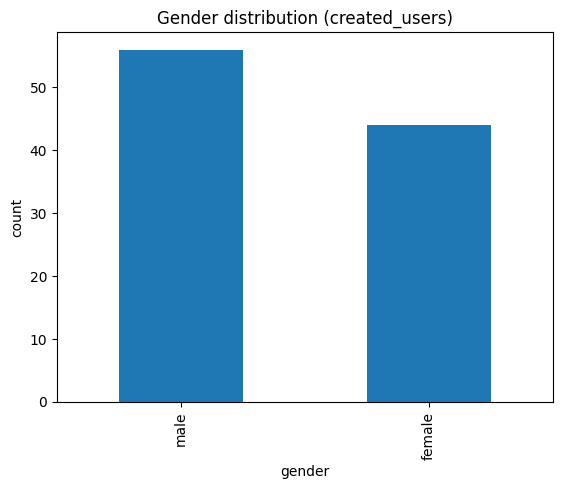

In [23]:
import matplotlib.pyplot as plt

# Chart 1: gender distribution (if present)
if "gender" in df.columns:
    ax = df["gender"].value_counts().plot(kind="bar")
    ax.set_title("Gender distribution (created_users)")
    ax.set_xlabel("gender")
    ax.set_ylabel("count")
    plt.show()
else:
    print("No 'gender' column found.")


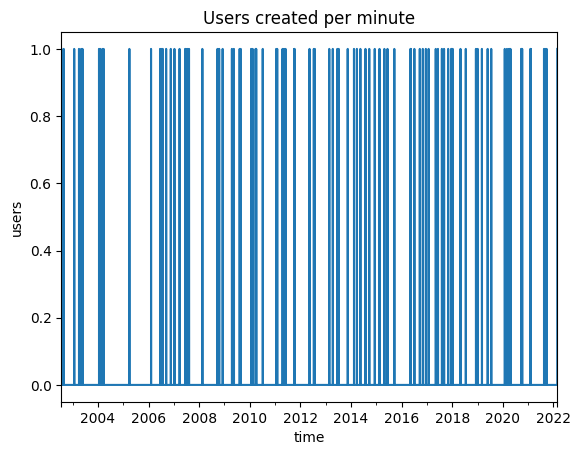

In [21]:
# Chart 2: users created per minute (if registered_date parsed)
if "registered_date" in df.columns and df["registered_date"].notna().any():
    tmp = df.dropna(subset=["registered_date"]).set_index("registered_date")
    ax = tmp.resample("1min").size().plot()
    ax.set_title("Users created per minute")
    ax.set_xlabel("time")
    ax.set_ylabel("users")
    plt.show()
else:
    print("registered_date not available or not parseable.")


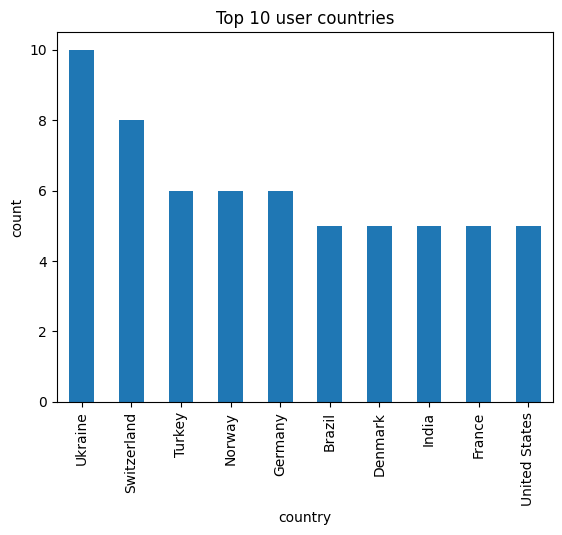

In [22]:
# Geographic Distribution (Country Count)
# Extract country from address (last token)
countries = df["address"].astype(str).str.split(",").str[-1].str.strip()

ax = countries.value_counts().head(10).plot(kind="bar")
ax.set_title("Top 10 user countries")
ax.set_xlabel("country")
ax.set_ylabel("count")
plt.show()

